# 1. Constant gaussian white noise (when we can talk about concentration)


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$

Where:
- $a, b$: dynamic variables (e.g., population levels, concentrations)
- $P, N$: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

We firsty considers noise over N and P.

## 1.1 Symmetrical system

By symmetrical, we mean that all constants $\lambda, \eta, \mu$ are equal for a and b. 
We assume there exists intrinsic fluctuations on the entries
. As fluctuations are assumed to be independants btw each others wrt to time and space (white), and considering CLTn we choose a gaussian white noise, where the concentration value is drawn from $N=N_{grid}+\eta_N$. For now, the noise is time independant


Here the frontier equation is just $P=N$

### 1.1.1 Dynamics and plane classification

In [ ]:
# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0

# --- Parameter grid for numerical integration ---
nb_of_points = 50
P_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure P is positive
N_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure N is positive

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = [1e-6, 1e-6]  # Initial a and b

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
from itertools import product



# System equations
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Return final a and b



# --- Generate data ---
results = []  # to store (noisy P, noisy N, steady state a, steady state b)
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # Ensure P stays positive
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # Ensure N stays positive
    
    # Integrate the ODE dynamics with the noisy parameters
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clip values into a reasonable range (0 to 10) for visualization
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]





  0%|          | 0/2500 [00:00<?, ?it/s]

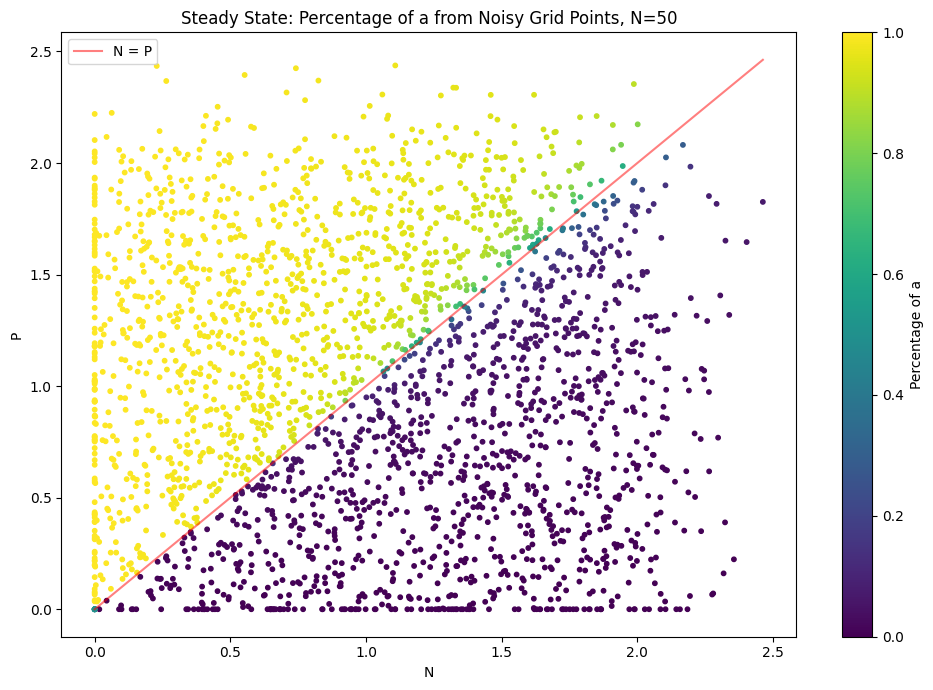

In [46]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))

# Compute percentage of a (a / (a + b))
a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)  # Avoid division by zero

# Plot with a single colormap based on the percentage of a
sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(f"Steady State: Percentage of a from Noisy Grid Points, N={nb_of_points}")
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")
# Plot the diagonal line N = P
min_val = min(np.min(N_plot), np.min(P_plot))
max_val = max(np.max(N_plot), np.max(P_plot))
ax.plot([min_val, max_val], [min_val, max_val], color='red',alpha=0.5,  label='N = P')

ax.legend()


plt.tight_layout()
plt.show()

up to now, we've used a fully symmetrical version of the system, whose parameters are symetrical 
$$ \begin{aligned} \eta_a &= 0.1 \\ \eta_b &= 0.1 \\ \mu_a &= 0.2 \\ \mu_b &= 0.2 \\ k_a &= 0.7 \\ k_b &= 0.7 \\ \lambda_a &= 1.0 \\ \lambda_b &= 1.0 \end{aligned} $$
As a consequence, when we exactly have N=P, we end up in a 50/50 final concentration of a and b (first graph)
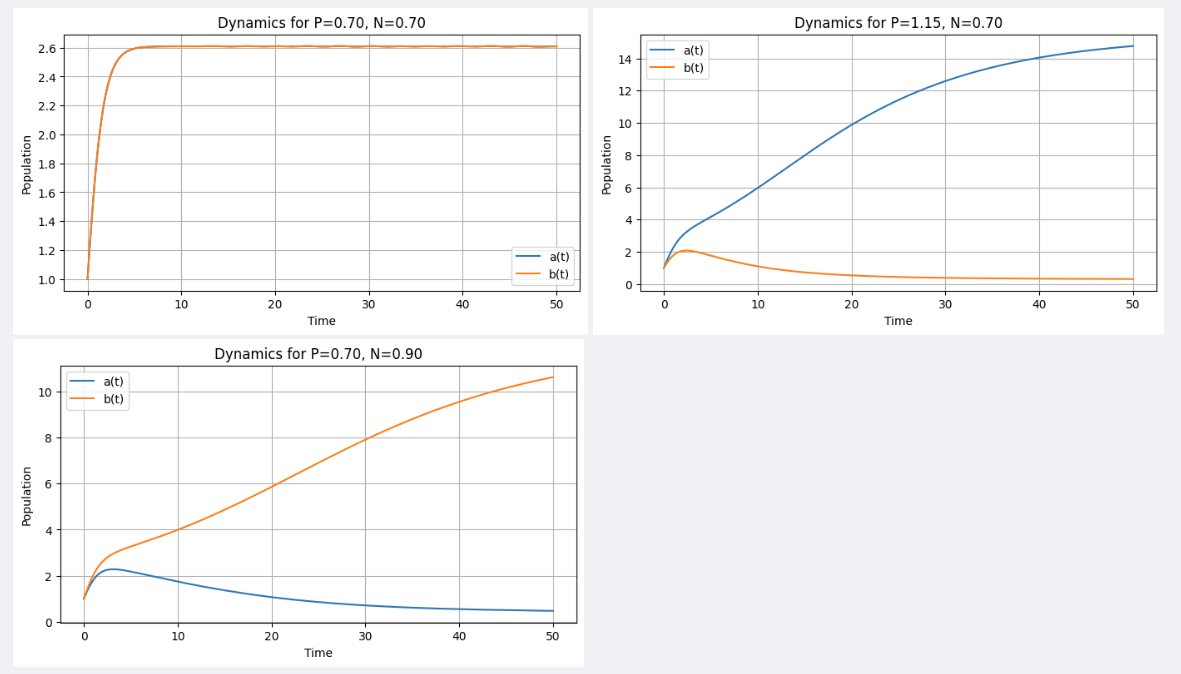

This is no surprise : the higher is the difference between N and P (ie the further away we are from the diagonal N=P), the fastest it takes for one species to win over the other. For N=P, this time is infinite. 

### 1.1.2 Density profile analysis of the frontier, as a function of the computation time

**(a) Without noise**

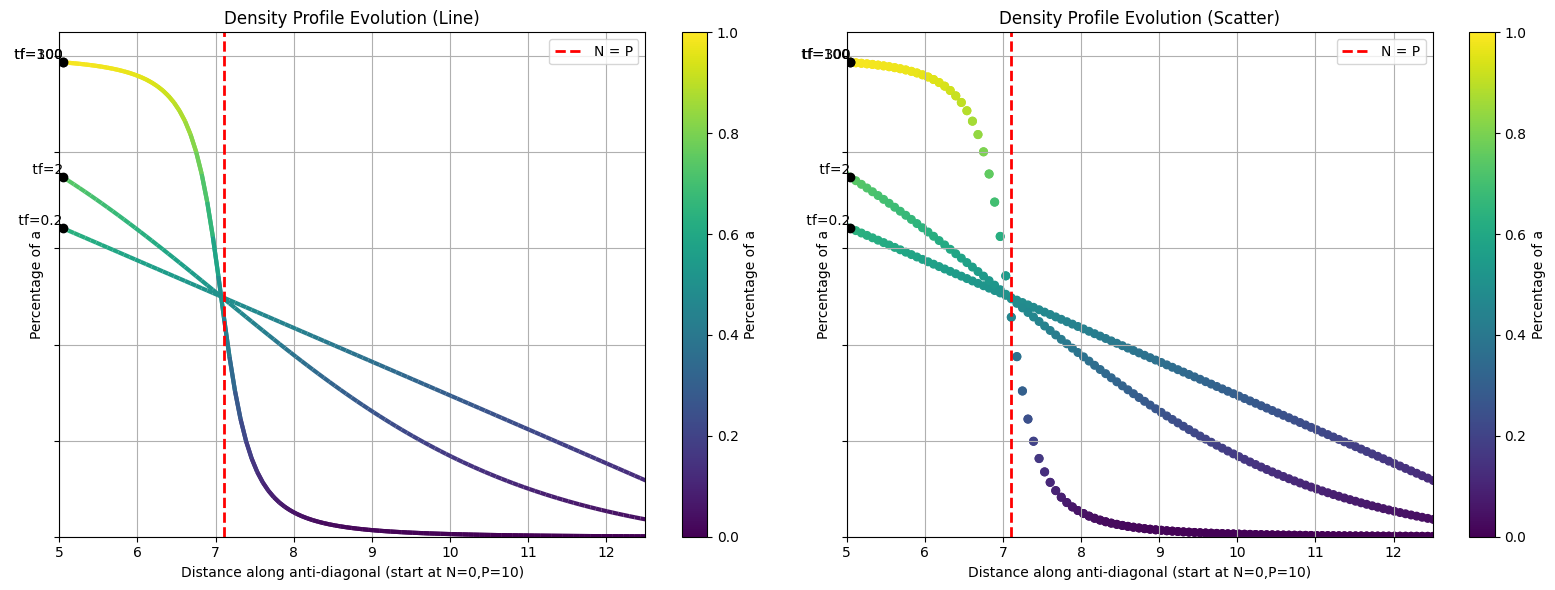

**(b) With noise**

In [ ]:
# --- System parameters ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b   = 0.2, 0.2
k_a, k_b     = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

num_points = 200

# --- Noise & integration setup ---
noise_sigma = 0.1
y0 = [1e-6, 1e-6]

# --- Final times to compare transient vs steady ---
tf_list = [0.2, 2, 100,300]

# Set desired plot ranges here:
x_min, x_max = 5, 12.5
y_min_plot, y_max_plot = 0, 1.05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.collections import LineCollection
from tqdm import tqdm


# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    t_eval=t_eval, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Parameterize anti-diagonal from (N=0, P=10) to (N=10, P=0) ---

t_line = np.linspace(0, 1, num_points)
N_diag = 10 * t_line
P_diag = 10 * (1 - t_line)
distance_diag = 10 * np.sqrt(2) * t_line



# --- Compute percentage-of-a profiles ---
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    profile = np.zeros(num_points)
    for i in range(num_points):
        noisy_N = max(0, N_diag[i] + np.random.normal(scale=noise_sigma))
        noisy_P = max(0, P_diag[i] + np.random.normal(scale=noise_sigma))
        a_f, b_f = integrate_ode(noisy_P, noisy_N, y0, (0, tf))
        profile[i] = np.clip(a_f / (a_f + b_f + 1e-10), 0, 1)
    profiles[tf] = profile

# --- Prepare colormap ---
all_vals = np.concatenate(list(profiles.values()))
norm = plt.Normalize(vmin=all_vals.min(), vmax=all_vals.max())
cmap = plt.cm.viridis

# --- Compute where N = P on the anti-diagonal ---
idx_eq = np.argmin(np.abs(N_diag - P_diag))
distance_eq = distance_diag[idx_eq]



Processing tf values: 100%|██████████| 4/4 [00:30<00:00,  7.61s/it]


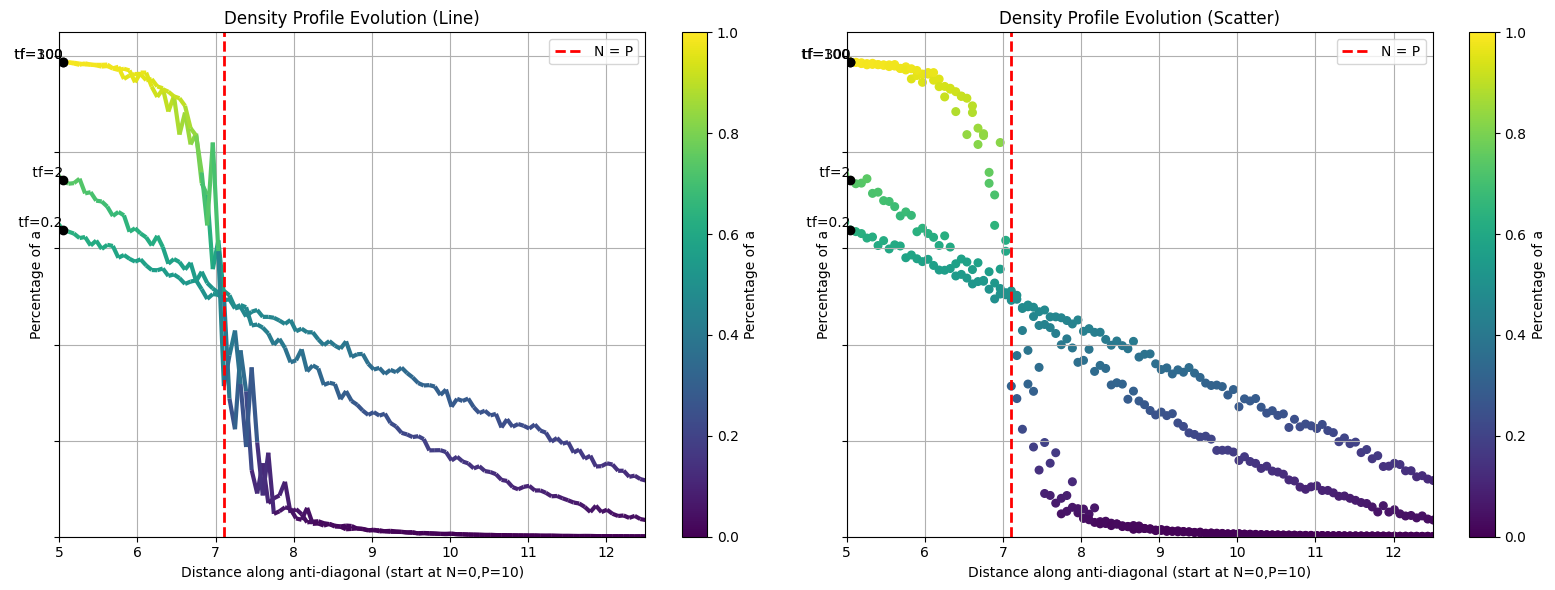

In [ ]:
# --- Plotting ---

# Find an index for annotation in the visible window
annotate_index = np.where((distance_diag >= x_min) & (distance_diag <= x_max))[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Line plot with colored segments
for tf, profile in profiles.items():
    points   = np.vstack([distance_diag, profile]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    seg_colors = [(cmap(norm((profile[i] + profile[i+1]) / 2))) for i in range(len(profile)-1)]
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax1.add_collection(lc)
    # annotate at the first visible point
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax1.plot(d0, p0, 'ko')
    ax1.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax1.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min_plot, y_max_plot)
ax1.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax1.set_ylabel("Percentage of a")
ax1.set_title("Density Profile Evolution (Line)")
ax1.grid(True)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
plt.colorbar(sm1, ax=ax1, label="Percentage of a")
ax1.legend()

# Remove y-axis tick labels
ax1.set_yticklabels([])

# Scatter plot
for tf, profile in profiles.items():
    ax2.scatter(distance_diag, profile, c=profile, cmap=cmap, norm=norm, s=30)
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax2.plot(d0, p0, 'ko')
    ax2.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax2.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min_plot, y_max_plot)
ax2.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax2.set_ylabel("Percentage of a")
ax2.set_title("Density Profile Evolution (Scatter)")
ax2.grid(True)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label="Percentage of a")
ax2.legend()

# Remove y-axis tick labels
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()




We can see that early stopping freeze most of neurons in a undecided state. The biggest is the noise, the more probable is to find false positive of the classification nearby the frontier. 

## 1.2 Asymmetrical system


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$


In this section, we want to probe the effect of introducing asymmetry between $\alpha, \eta,\mu$ parameters for a and b, leading to a non N=P frontier.

First, as assumed in our computations, we take $\mu_a=\mu_b$ and $\eta_a=\eta_b$.

- We can define the Michaelis constant $K_a=1/k_a$, which mean the higher $k_a$ is, the lower $K_a$ is, hence, the faster the process reaches full speed saturation.

- $\alpha_a$ holds for the autocathalytic rate

If we want to introduce asymmetry, we can start by probing the effect of $k_a$ and $\alpha_a$


In [ ]:
# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
from itertools import product



# System equations
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Return final a and b

# --- Parameter grid for numerical integration ---
nb_of_points = 30
P_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure P is positive
N_grid = np.linspace(0.0, 2.0, nb_of_points)  # Ensure N is positive

# Noise parameters
noise_sigma = 0.2  # standard deviation of the Gaussian noise

# Time span and initial condition for the ODE
t_span_full = (0, 100)
y0 = [1e-6, 1e-6]  # Initial a and b

# --- Generate data ---
results = []  # to store (noisy P, noisy N, steady state a, steady state b)
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    # Add independent Gaussian white noise to each grid coordinate
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # Ensure P stays positive
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # Ensure N stays positive
    
    # Integrate the ODE dynamics with the noisy parameters
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clip values into a reasonable range (0 to 10) for visualization
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]


  0%|          | 0/900 [00:00<?, ?it/s]

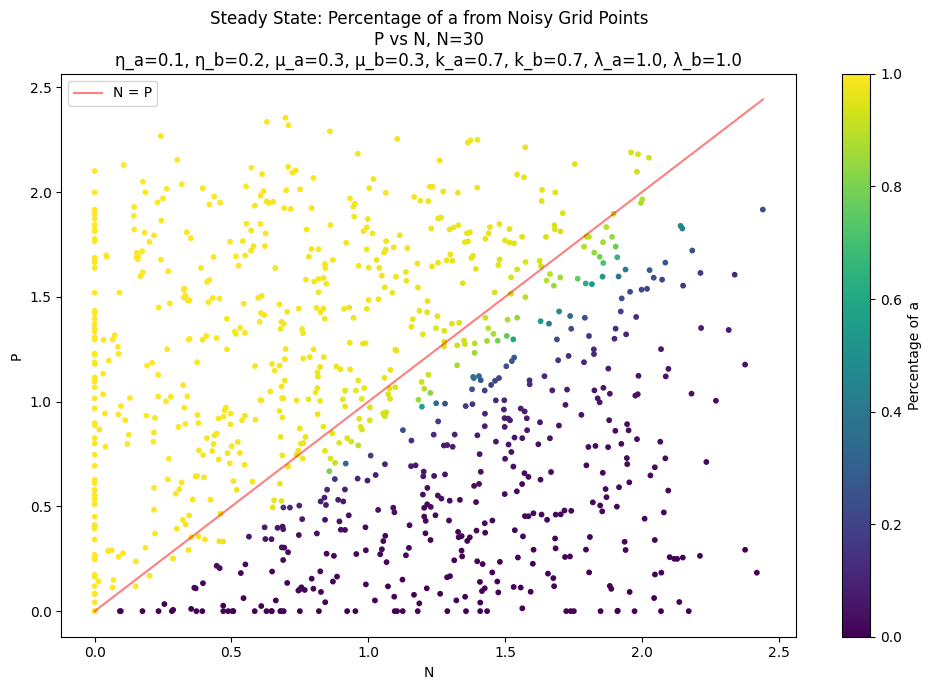

In [38]:
# --- Plot the phase diagram using the noisy grid points ---
fig, ax = plt.subplots(figsize=(10, 7))

# Compute percentage of a (a / (a + b))
a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)  # Avoid division by zero

# Plot with a single colormap based on the percentage of a
# Build dynamic title with all parameters
title = (
    f"Steady State: Percentage of a from Noisy Grid Points\n"
    f"P vs N, N={nb_of_points}\n"
    f"η_a={eta_a}, η_b={eta_b}, μ_a={mu_a}, μ_b={mu_b}, "
    f"k_a={k_a}, k_b={k_b}, λ_a={lambda_a}, λ_b={lambda_b}"
)

# Plot with a single colormap based on the percentage of a
sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(title)
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")
# Plot the diagonal line N = P
min_val = min(np.min(N_plot), np.min(P_plot))
max_val = max(np.max(N_plot), np.max(P_plot))
ax.plot([min_val, max_val], [min_val, max_val], color='red',alpha=0.5,  label='N = P')

ax.legend()


plt.tight_layout()
plt.show()

### $\mu_a$ and $\mu_b$

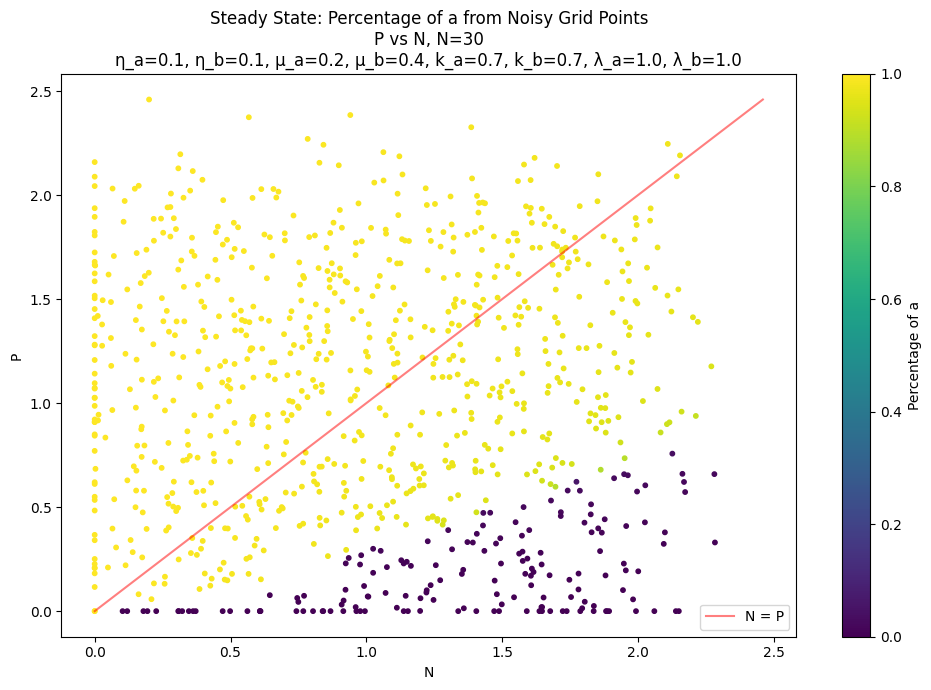
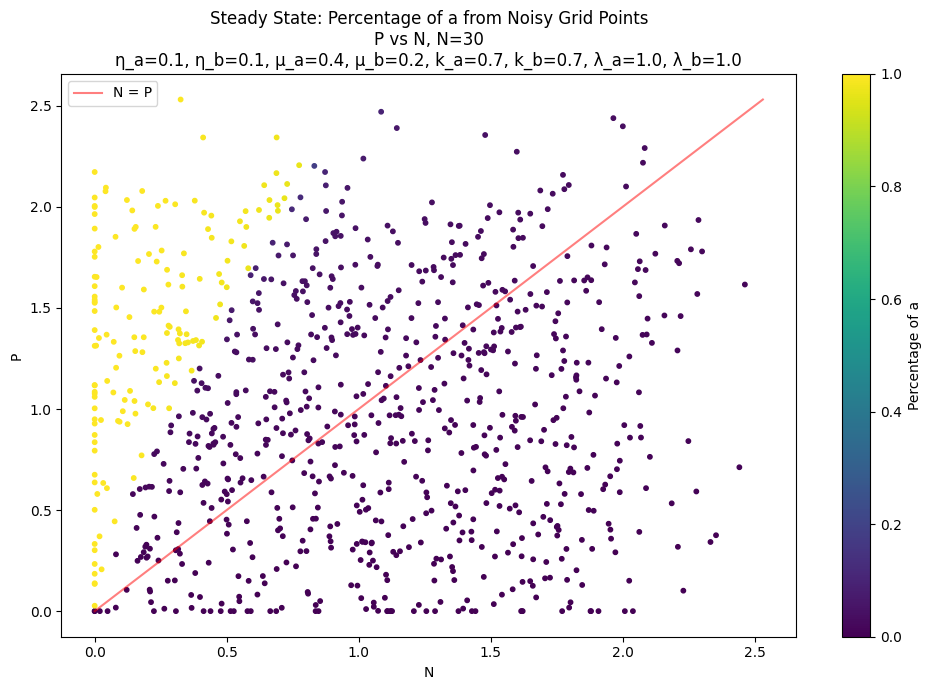

### $k_a$ and $k_b$ 

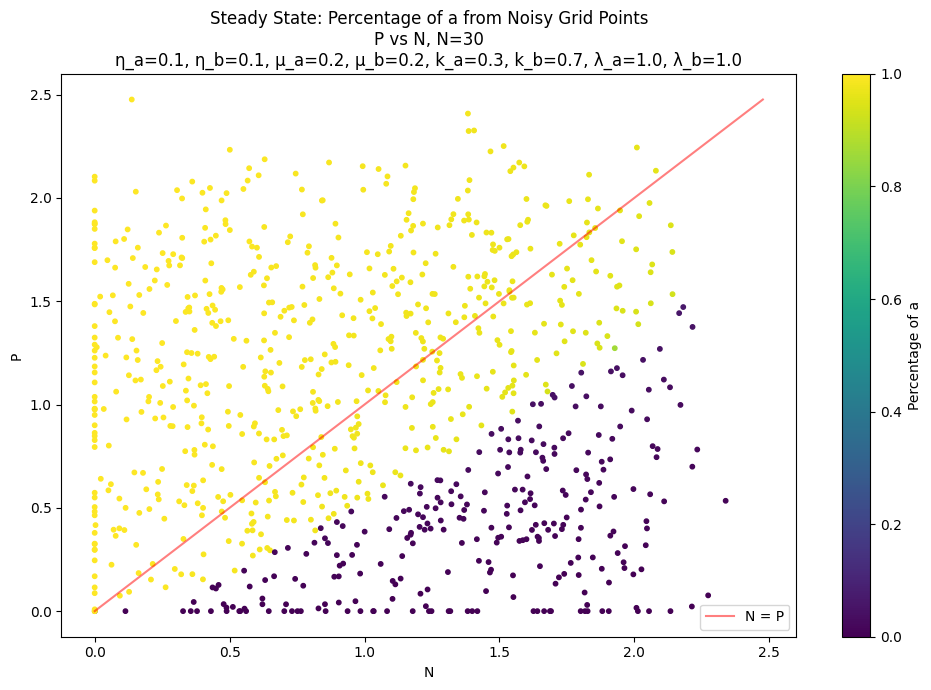
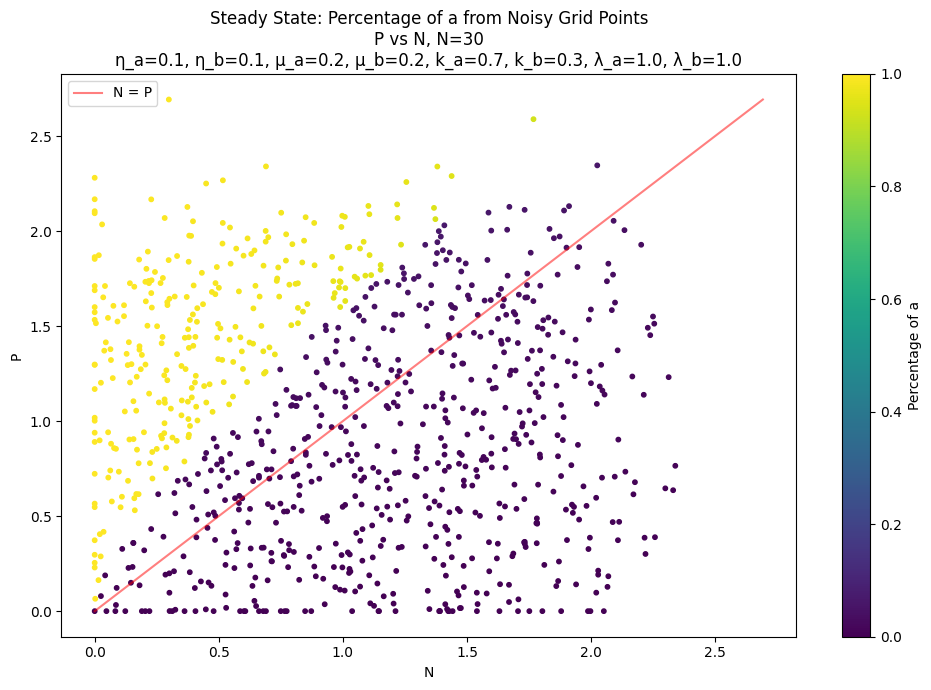

### $\eta_a$ and $\eta_b$

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

FIND A FRONTIER EQUATION WHICH IS A FUNCVTION OF ka lambdaa AND SEE HOW IT BEHAVES AS WE MODIFY THOSE VALUES